<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/1_example_load_data_from_ftx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get FTX Market Data 

Example of using custom functions to pull data from FTX APIs.

Note that most of this data is available in the lab datasets - and it's probably more convenient to use that instead, rather than pull it yourself.

## Load libraries

Note: if your analysis needs further packages, add their dependencies to `dependecies` and the packages you need loaded to `libs_to_load`:

In [1]:
# snippet: rw load rwrtools v0.4

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here")

# comment out next two lines if not loading rsims
rsims_dependencies <- c("stringr", "lubridate", "roll", "Rcpp")
dependencies <- c(dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies)
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

* checking for file ‘/tmp/RtmpbKjOVo/remotes3a725e849a/RWLab-rwRtools-985e440/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.17.tar.gz’



## Functions for getting market data from FTX API

In [2]:
#' Get Single FTX Market v0.1
#' 
#' @description Get market data for a single FTX market.
#'
#' @param market name of the market (string)
#' @param resolution representing aggregation length in seconds (int)
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_single_ftx_market("BTC-PERP", resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_single_ftx_market <- function(market, resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30") {
  endpoint <- "https://ftx.com/api"
  start_time <- as.numeric(as.POSIXct(start_time, tz = "UTC"))
  end_time <- as.numeric(as.POSIXct(end_time, tz = "UTC"))
  
  res <- httr::GET(glue::glue("{endpoint}/markets/{market}/candles?resolution={resolution}&start_time={start_time}&end_time={end_time}")) 
  
  res_json <- res$content %>% 
    rawToChar() %>% 
    jsonlite::fromJSON()
  
  if(res_json$success == TRUE) {
    prices <- res_json %>% 
      purrr::pluck("result") %>% 
      dplyr::mutate(datetime = lubridate::as_datetime(startTime)) %>% 
      dplyr::select(-startTime, -time)
    
    return(prices)
  } else {
    print("Request failed.")
    
    return(res_json)
  }
}

#' Get Multiple FTX Markets v0.1
#' 
#' @description Get market data for multipole FTX markets.
#'
#' @param market name of the markets (vector of string)
#' @param resolution representing aggregation length in seconds (int)
#' @param start_time human readable start time in UTC (string)
#' @param end_time human readable end time in UTC (string)
#'
#' @return dataframe of prices if API call was successful, otherwise call result
#' @export
#'
#' @examples
#' get_multiple_ftx_markets(c("BTC-PERP", "ETH-PERP"), resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30)
get_multiple_ftx_markets <- function(markets, resolution = 86400, start_time = "2019-07-20", end_time = "2022-06-30") {
  prices <- data.frame()
  for(market in markets) {
    these_prices <- get_single_ftx_market(market, resolution = resolution, start_time = start_time, end_time = end_time)
    if(!is.null(these_prices)) {
      these_prices <- these_prices %>% 
        dplyr::mutate(ticker = market)
      
      prices <- dplyr::bind_rows(prices, these_prices)
    } else {
      print(glue("Failed to get data for market {market}"))
    }
  }
    
    prices
}

## Download and plot data for a single market

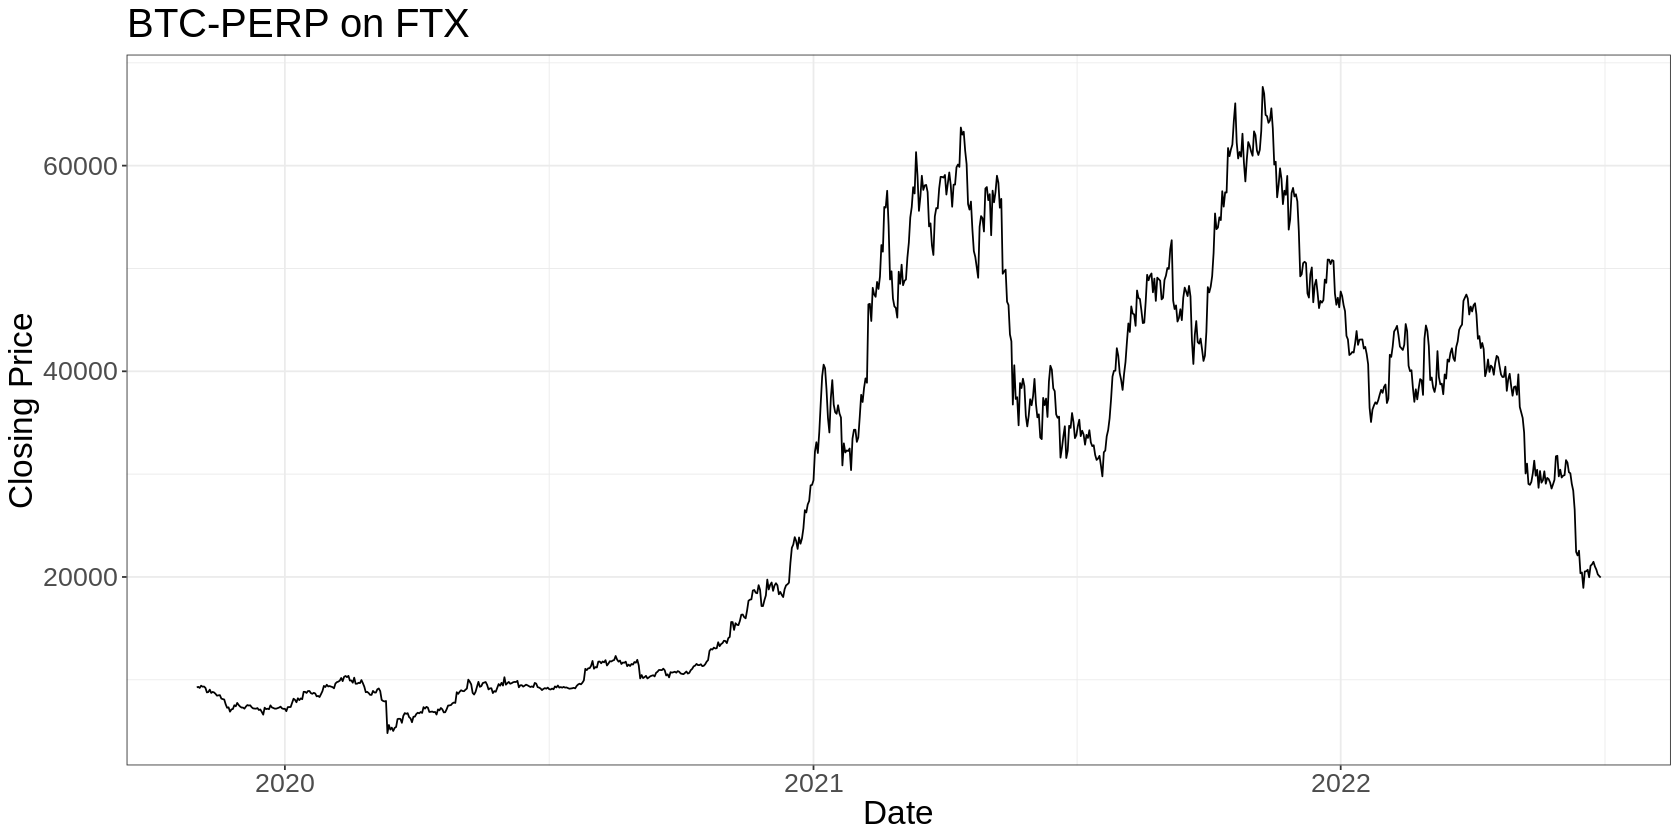

In [3]:
market <- "BTC-PERP"
resolution <- 60*60*24  # in seconds
start_time <- "2019-11-01"
end_time <- "2022-06-30"

prices <- get_single_ftx_market(market, resolution, start_time, end_time)
prices %>% 
  ggplot(aes(x = datetime, y = close)) +
  geom_line() +
  labs(
    x = "Date",
    y = "Closing Price",
    title = "BTC-PERP on FTX"
  )

## Download and plot data for multiple markets

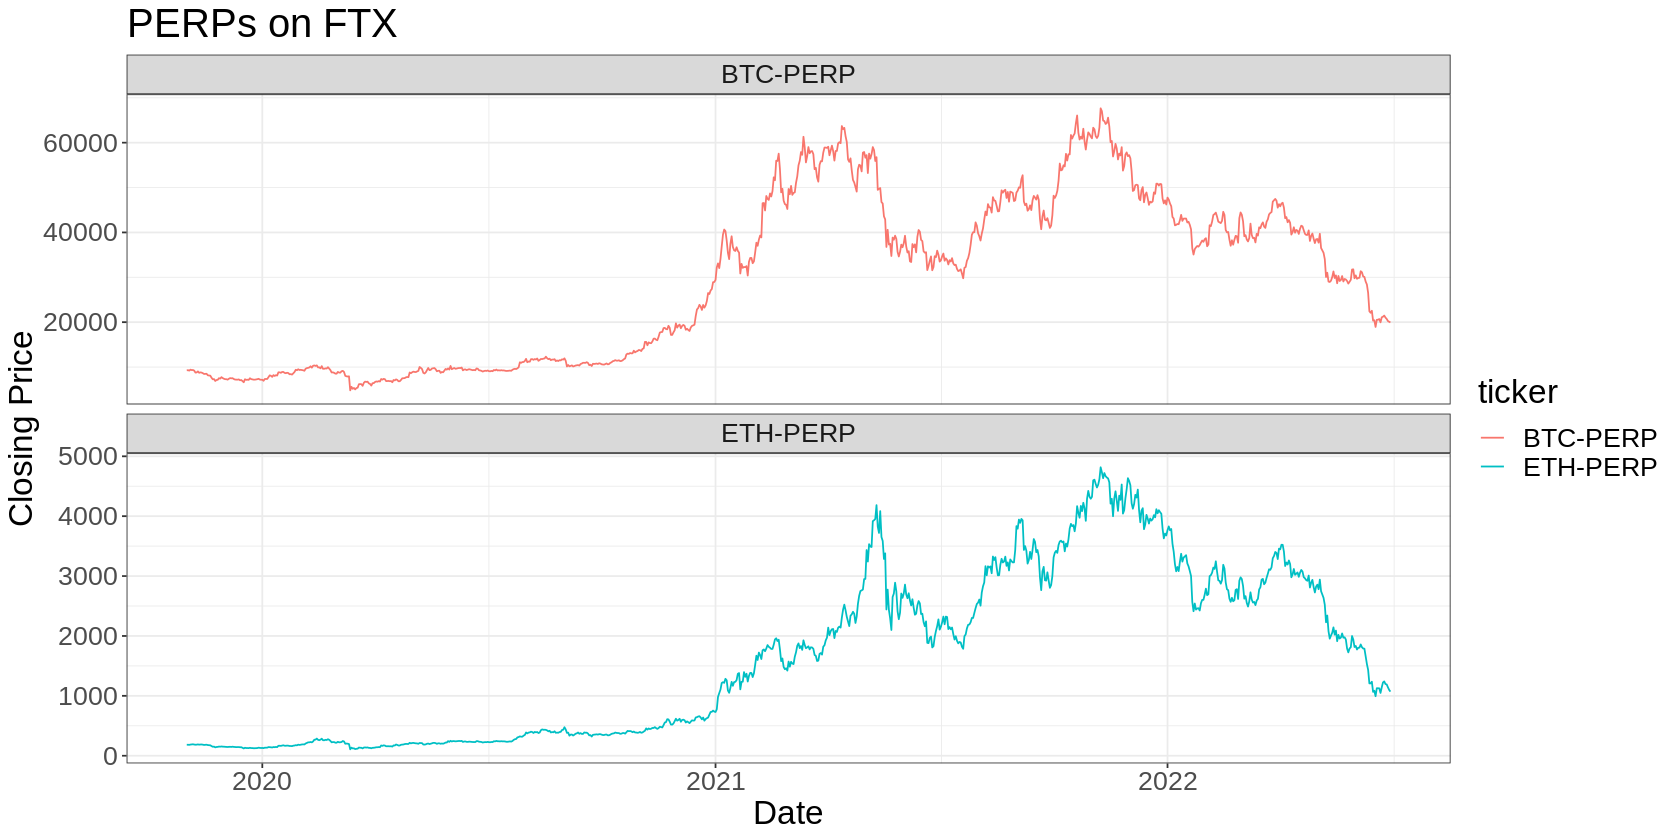

In [4]:
markets <- c("BTC-PERP", "ETH-PERP")
prices <- get_multiple_ftx_markets(markets, resolution, start_time, end_time)
prices %>% 
  ggplot(aes(x = datetime, y = close, colour = ticker)) +
  geom_line() +
  facet_wrap(~ticker, ncol = 1, scales = "free_y") +
  labs(
    x = "Date",
    y = "Closing Price",
    title = "PERPs on FTX"
  )